In [17]:
include("eq1d_func.jl")
using NPZ
prefix = "/central/groups/esm/dzhuang/cost-accuracy-data/"


"/central/groups/esm/dzhuang/cost-accuracy-data/"

# Darcy equation solver
$$-\nabla (a \nabla u) = f$$

In [18]:
as = npzread(prefix*"darcy_a.npy")
us_ref = npzread(prefix*"darcy_u.npy")


Ne_ref = size(as, 2) - 1
Nes = [2^3; 2^4; 2^5; 2^6; 2^7; 2^8; 2^9; 2^10; 2^11]
Δxs = 1.0 ./ Nes

test_id = Array(1:10)
Ntest = length(test_id)
errors = zeros(length(Nes), Ntest)
rel_errors = zeros(length(Nes), Ntest)
for (i, Ne) in enumerate(Nes)
    f = 100*ones(Ne + 1)
    
    for j in test_id
        a  = as[j, 1:Int64(Ne_ref/Ne):end]
        u_ref = us_ref[j, 1:Int64(Ne_ref/Ne):end]
        
        u = solve_Darcy_1D(a, f)
        
        errors[i, j] = norm(u - u_ref)/sqrt(Ne)
        rel_errors[i, j] = norm(u - u_ref)/norm(u_ref)
    end
end

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/dzhuang/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


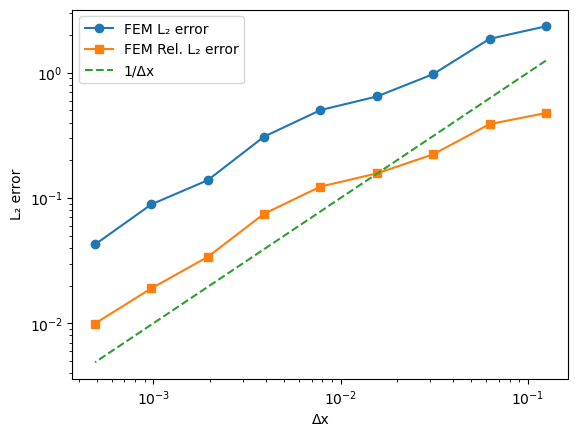

PyObject <matplotlib.legend.Legend object at 0x7fc3f56e3fd0>

In [19]:
num_mean_errors = sum(errors, dims=2)/Ntest
num_mean_rel_errors = sum(rel_errors, dims=2)/Ntest
num_costs = 17*Nes
PyPlot.figure()
PyPlot.loglog(Δxs, num_mean_errors, "-o", label="FEM L₂ error")
PyPlot.loglog(Δxs, num_mean_rel_errors, "-s", label="FEM Rel. L₂ error")
PyPlot.loglog(Δxs, 10*Δxs.^1, "--", label="1/Δx")
PyPlot.xlabel("Δx")
PyPlot.ylabel("L₂ error")
PyPlot.legend()


# FNO results

In [21]:
n_data_array = [256 512 1024 2048 4096 8192 16384]
k_max_array = [16 32 64 128] 
d_f_array = [16 32 64 128]
n_fno_layers_array = [3 4 5 6]
downsample_ratio_array = [1 2 4 8]
       
epochs = 2
n_train_repeat = 2

data_analysis = zeros(length(n_data_array)*length(downsample_ratio_array)*length(n_fno_layers_array)*length(k_max_array)*length(d_f_array), 5+(3*epochs+1)*n_train_repeat)
i_data_analysis = 0

for n_data in n_data_array
    for k_max in k_max_array
        for d_f in d_f_array
            for n_fno_layers in n_fno_layers_array
                for downsample_ratio in downsample_ratio_array
                    setup_info="n_data_"*string(n_data)*"_k_max_"*string(k_max)*"_downsample_ratio_"*string(downsample_ratio)*"_n_fno_layers_"*string(n_fno_layers)*"_d_f_"*string(d_f)
                    file_name = prefix*"data/darcy_analysis_"*setup_info*".npy"
                    
                    if isfile(file_name)
                        i_data_analysis += 1
                        data_analysis[i_data_analysis, :] = npzread(file_name)
                        
                    end
                end
            end
        end
    end
end
data_analysis = data_analysis[1:i_data_analysis, :]

#data_analysis[i_data_analysis,5+i_train_repeat*(3*epochs+1):5+(i_train_repeat+1)*(3*epochs+1)] 
# = np.hstack((train_rel_l2_losses, test_rel_l2_losses, test_l2_losses, cost))

fno_mean_errors = sum(data_analysis[:, (5+3*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_mean_rel_errors = sum(data_analysis[:, (5+2*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_costs = data_analysis[:, end];


# cost-accuracy tradeoff

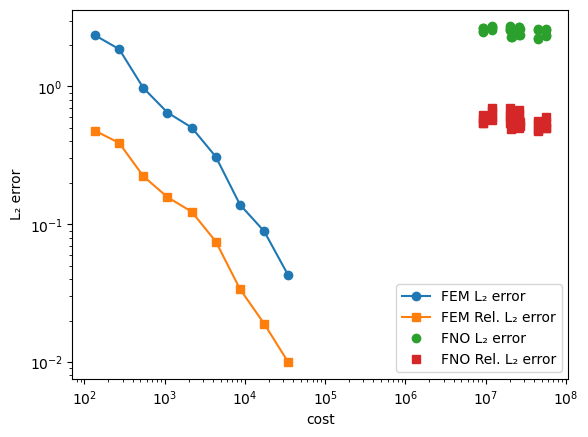

PyObject <matplotlib.legend.Legend object at 0x7fc3eec7d6d0>

In [25]:
PyPlot.figure()
PyPlot.loglog(num_costs, num_mean_errors, "-o", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors, "-s", label="FEM Rel. L₂ error")
PyPlot.loglog(fno_costs, fno_mean_errors, "o", label="FNO L₂ error")
PyPlot.loglog(fno_costs, fno_mean_rel_errors, "s", label="FNO Rel. L₂ error")

PyPlot.xlabel("cost")
PyPlot.ylabel("L₂ error")
PyPlot.legend()

# Heat equation
$$
u_t - \triangle u = f
$$

In [4]:
u0s = npzread(prefix*"heat_u0.npy")
fs = npzread(prefix*"heat_f.npy")
us_ref = npzread(prefix*"heat_u.npy")

   

Nes = [2^4; 2^5; 2^6; 2^7; 2^8; 2^9; 2^10; 2^11;]
Δxs = 1.0 ./ Nes
T = 1.0/8
test_id = Array(1:10)
Ntest = length(test_id)
errors = zeros(length(Nes), Ntest)
rel_errors = zeros(length(Nes), Ntest)



for (i, Ne) in enumerate(Nes)
    
    Δt = 1/Ne
    Nt = Int64(T/Δt)
    
    for j in test_id
        u0  = u0s[j, 1:Int64(Ne_ref/Ne):end]
        u_ref = us_ref[j, 1:Int64(Ne_ref/Ne):end]
        f = fs[j, 1:Int64(Ne_ref/Ne):end]
        
        u = solve_heat_1D(u0, f, Δt, Nt)
        
        errors[i, j] = norm(u - u_ref)/sqrt(Ne)
        rel_errors[i, j] = norm(u - u_ref)/norm(u_ref)
    end
end




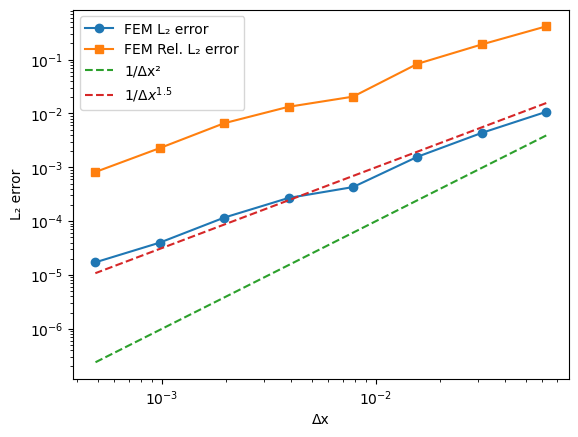

PyObject <matplotlib.legend.Legend object at 0x7fdef1380e10>

In [6]:
mean_errors = sum(errors, dims=2)/Ntest
mean_rel_errors = sum(rel_errors, dims=2)/Ntest
PyPlot.figure()
PyPlot.loglog(Δxs, mean_errors, "-o", label="FEM L₂ error")
PyPlot.loglog(Δxs, mean_rel_errors, "-s", label="FEM Rel. L₂ error")
PyPlot.loglog(Δxs, Δxs.^2, "--", label=L"$1/Δx^2$")
PyPlot.loglog(Δxs, Δxs.^1.5, "--", label=L"$1/Δx^{1.5}$")

PyPlot.xlabel("Δx")
PyPlot.ylabel("L₂ error")
PyPlot.legend()


